----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import misc
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Dense, Input, merge, Convolution2D, MaxPooling2D
from keras.layers import Dropout, Flatten
#Code structure to import .mat file
def mat_open(f):
    data= {}
    data['height'] = []
    data['label'] = []
    data['left'] = []
    data['top'] = []
    data['width'] = []
    data['names'] = []
    def get_bbox(name, obj):
        vals = []
        if obj.shape[0] == 1:
            vals.append(obj[0][0])
        else:
            for k in range(obj.shape[0]):
                vals.append(f[obj[k][0]][0][0])
        data[name].append(vals)


    for item in f['digitStruct/bbox']:
        f[item[0]].visititems(get_bbox)
    def get_name(index, hdf5_data):
        name = hdf5_data['/digitStruct/name']
        return ''.join([chr(v[0]) for v in hdf5_data[name[index][0]].value])
    for index in range(0,f['/digitStruct/name'].shape[0]):
        data['names'].append(get_name(index,f))
    #Make labels 6 digits long
    for label in data['label']:
        num_dig = len(label)
        if len(label)<5:
            label+=[0 for item in range(0,5-len(label))]
        label+=[num_dig]
    #find right and bottom of bounding box
    for key in data:
        data[key]=np.asarray([np.asarray(obj) for obj in data[key]])
    data['right'] =data['left']+data['width']
    data['bottom'] = data['top']+data['height']
    
    data['unified_label']=np.zeros((len(data['label']),data['label'][0].shape[0]))

    for i in range(0,len(data['label'])):
        data['unified_label'][i,:] = data['label'][i][0:6]
    return data

Using TensorFlow backend.


In [2]:
train_file = h5py.File('train/train/digitStruct.mat')
data=mat_open(train_file)
test_file = h5py.File('test/test/digitStruct.mat')
test_data=mat_open(test_file)

In [3]:
import cPickle as pickle
pickle.dump( data, open( "data.p", "wb" ) )
pickle.dump( test_data, open( "test_data.p", "wb" ) )

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import misc
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Dense, Input, merge, Convolution2D, MaxPooling2D
from keras.layers import Dropout, Flatten
import cPickle as pickle
data = pickle.load(open('data.p', 'rb'))
test_data = pickle.load(open('test_data.p', 'rb'))

Using TensorFlow backend.


In [2]:
#Read image data into numpy array
def image_read(name_data, path):
    image_list = []
    for image_name in name_data:
        image_list.append(misc.imread(path+image_name))
    return np.asarray(image_list)

In [3]:
#Shrinks image down to 54x54 based on bbox.  Reformats charecter bboxes to be ratio of new bbox.
def crop_scale(data):
    data['boxes']= [None]*len(data['image'])
    for index in range(0,len(data['image'])):
        top=int(max(data['top'][index].min(),0))
        bottom = int(data['bottom'][index].max())
        left = int(max(data['left'][index].min(),0))
        right = int(data['right'][index].max())
        width = right - left
        height = bottom - top
        data['image'][index] = data['image'][index][top:bottom,left:right,:]
        data['image'][index] = misc.imresize(data['image'][index],(54,54),interp='bicubic')
        null = np.full((5-len(data['top'][index])),-.5)
        data['boxes'][index] = np.concatenate((np.concatenate((np.divide(np.subtract(data['top'][index],top),height),null)),
        np.concatenate((np.divide(np.subtract(data['bottom'][index],top),height),null)),
        np.concatenate((np.divide(np.subtract(data['left'][index],left),width),null)),
        np.concatenate((np.divide(np.subtract(data['right'][index],left),width),null))))

## One hot

In [8]:
print np.argmax(data['unified_label'][:,5])
data['unified_label'][29929,5]=5.0
#data['unified_label'][29929]=data['unified_label'][29929,0:5]
print data['unified_label'][29929].shape

4110
(6,)


In [5]:
num_out = 6
data['hot_label'] = np.zeros((data['unified_label'].shape[0],num_out,11))
test_data['hot_label'] = np.zeros((test_data['unified_label'].shape[0],num_out,11))
for digit in range(0,num_out):
    #print data['unified_label'].shape
    data['hot_label'][:,digit,:] = np_utils.to_categorical(data['unified_label'][:,digit],11)
    test_data['hot_label'][:,digit,:] = np_utils.to_categorical(test_data['unified_label'][:,digit],11)
print data['hot_label'][2],data['label'][2]

[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]] [ 2.  5.  0.  0.  0.  2.]


In [26]:
from keras import backend as K #import mean_squared_error, categorical_cross_entropy
def custom_loss(y_true, y_pred):
    dig_loss = 0.0
    for itr in xrange(6):
        dig_loss += K.categorical_crossentropy(y_pred[itr],y_true[itr])
    box_loss = K.mean(K.square(y_pred[6] - y_true[6]), axis=-1)
    return dig_loss

In [38]:
loss_list = ['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy','categorical_crossentropy',
            'categorical_crossentropy', 'categorical_crossentropy', 'mean_squared_error']
metric_list = ['accuracy']*7

In [41]:
from keras.layers.normalization import BatchNormalization
def large_cnn(num_outs):
    input_img=Input(shape=(54,54,3))
    con1 = Convolution2D(16, 9, 9, border_mode='valid', activation='relu')(input_img)
    pool1 = MaxPooling2D(pool_size=(2, 2))(con1)
    bnorm1 = BatchNormalization()(pool1)
    con2 = Convolution2D(32, 5, 5, border_mode='valid', activation='relu')(bnorm1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(con2)
    bnorm2 = BatchNormalization()(pool2)
    drop1 = Dropout(0.4)(bnorm2)
    con3 = Convolution2D(64, 3, 3, border_mode='valid', activation='relu')(drop1)
    bnorm3 = BatchNormalization()(con3)
    flat = Flatten()(bnorm3)
    den1 = Dense(128, activation='relu')(flat)
    den2 = Dense(128, activation='relu')(den1)
    drop2 = Dropout(0.4)(den2)
    outputs = []
    for itr in range(0,num_outs-1):
        outputs.append(Dense(11, activation='softmax')(drop2))
    outputs.append(Dense(5, activation='softmax')(drop2))
    outputs.append(Dense(20)(drop2))
    model = Model(input=input_img, output=outputs)
    model.compile(loss=loss_list, optimizer='adam', metrics=metric_list)
    return model

In [42]:
from math import floor, ceil
batch_size = 40
train_path = 'train/train/'
test_path = 'test/test/'
total_batches =int(floor(len(data['left'])/batch_size))
val_batches=int(ceil(0.1*total_batches))
train_batches=int(floor(0.9*total_batches))
print total_batches,val_batches, train_batches
batch = {}
# build the model
conv_net = large_cnn(6)

for epoch in xrange(1):
    for batch_itr in range(0,train_batches):
        start_index = batch_itr*batch_size
        stop_index = (batch_itr+1)*batch_size
        for key in data:
            batch[key]=data[key][start_index:stop_index]
        batch['image']=image_read(batch['names'],train_path)
        crop_scale(batch)
        batch['label_list']=[]
        for itr in range(0,5):
            batch['label_list'].append(batch['hot_label'][:,itr,:])
        batch['label_list'].append(batch['hot_label'][:,5,1:6])
        batch['label_list'].append(np.stack(batch['boxes']))
        batch['image'] = np.stack(batch['image'])/255.0-0.5
        # Fit the model
        conv_net.train_on_batch(batch['image'],batch['label_list'])
    
    
    #validation test
    start_index = train_batches*batch_size
    stop_index = (total_batches)*batch_size
    for key in data:
        batch[key]=data[key][start_index:stop_index]
    batch['image']=image_read(batch['names'],train_path)
    crop_scale(batch)
    batch['label_list']=[]
    for itr in range(0,5):
        batch['label_list'].append(batch['hot_label'][:,itr,:])
    batch['label_list'].append(batch['hot_label'][:,5,1:6])
    batch['label_list'].append(np.stack(batch['boxes']))
    batch['image'] = np.stack(batch['image'])/255.0-0.5
    # Fit the model
    print conv_net.evaluate(batch['image'],batch['label_list'],batch_size=400)
    print conv_net.metrics_names

835 84 751


ValueError: negative dimensions are not allowed

In [43]:
conv_net.save('CNNBBR.h5')

In [7]:
import keras
conv_net = keras.models.load_model('CNN3.h5')

In [48]:
batch = {}
start_index = 0
stop_index = 10
train_path = 'train/train/'
for key in data:
    batch[key]=data[key][start_index:stop_index]
batch['image']=image_read(batch['names'],train_path)
crop_scale(batch)
batch['label_list']=[]
for itr in range(0,5):
    batch['label_list'].append(batch['hot_label'][:,itr,:])
batch['label_list'].append(batch['hot_label'][:,5,1:6])
batch['label_list'].append(np.stack(batch['boxes']))
batch['image'] = np.stack(batch['image'])/255.0-0.5
# Fit the model
output =  conv_net.predict(batch['image'][0:2])
print output[6],'actual', batch['boxes'][0]

[[-0.02143433  0.05404833 -0.31387389 -0.3556993  -0.4565652   0.74669397
   0.66725802 -0.09718483 -0.28720307 -0.58583701  0.04955902  0.1517652
  -0.25621638 -0.30143821 -0.39364657  0.39713305  0.74850768 -0.15495181
  -0.4170087  -0.55384147]
 [-0.0445209   0.11869785 -0.5578531  -0.46936384 -0.50037581  0.94584537
   1.07606125 -0.50208211 -0.56442881 -0.43505296 -0.12832113  0.56031817
  -0.48561692 -0.4631331  -0.39875478  0.44625449  1.08492875 -0.52702188
  -0.52291441 -0.45558888]] actual [ 0.          0.01793722 -0.5        -0.5        -0.5         0.98206278
  1.         -0.5        -0.5        -0.5         0.          0.44508671
 -0.5        -0.5        -0.5         0.46820809  1.         -0.5        -0.5
 -0.5       ]


In [ ]:
start_index = 0
stop_index = 4000
batch = {}
train_path = 'train/train/'
for key in data:
    batch[key]=data[key][start_index:stop_index]
batch['image']=image_read(batch['names'],train_path)
#crop_scale(batch)
for itr in xrange(100):
    plt.figure()
    plt.imshow(batch['image'][itr])
    print batch['label'][itr]

In [ ]:

#batch['image'] = np.stack(batch['image'])/255.0-1.0
for itr in xrange(100):
    plt.figure()
    plt.imshow(batch['image'][itr])
    print batch['label'][itr]

In [23]:
start_index = 0
stop_index = 4000
for key in data:
    batch[key]=data[key][start_index:stop_index]
batch['image']=image_read(batch['names'],train_path)
crop_scale(batch)
batch['label_list']=[]
for itr in range(0,5):
    batch['label_list'].append(batch['hot_label'][:,itr,:])
batch['label_list'].append(batch['hot_label'][:,5,1:6])
batch['image'] = np.stack(batch['image'])/255.0-1.0
# Fit the model
#print conv_net.evaluate(batch['image'],batch['label_list'],batch_size=400)
#print conv_net.metrics_names

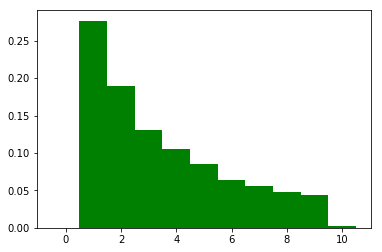

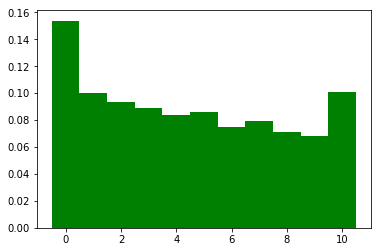

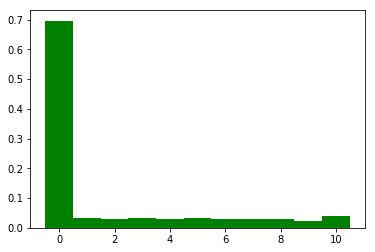

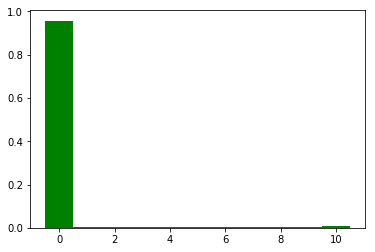

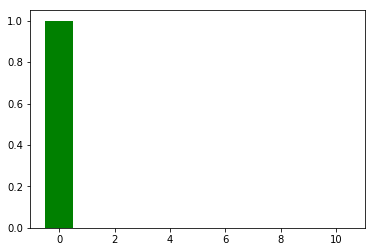

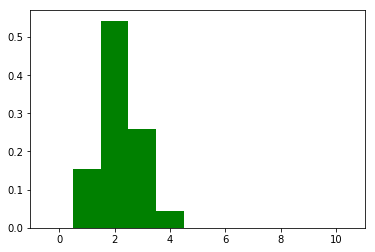

[array([ 0.        ,  0.27671996,  0.18924017,  0.13017185,  0.10511347,
        0.08469553,  0.06445722,  0.05619424,  0.04745225,  0.04344051,
        0.00251482]), array([ 0.15379319,  0.09975451,  0.0937369 ,  0.08891683,  0.08403688,
        0.085923  ,  0.0745165 ,  0.07903718,  0.07122328,  0.06828932,
        0.10077241]), array([ 0.69657506,  0.03377043,  0.02942938,  0.03164481,  0.02930962,
        0.03134543,  0.0285911 ,  0.02877073,  0.02814203,  0.02410035,
        0.03832106]), array([ 0.95676906,  0.00467038,  0.00449075,  0.0035926 ,  0.00482007,
        0.00401174,  0.00389198,  0.00344291,  0.00419137,  0.00362254,
        0.00649662]), array([  9.99700617e-01,   5.98766541e-05,   0.00000000e+00,
         5.98766541e-05,   0.00000000e+00,   5.98766541e-05,
         0.00000000e+00,   5.98766541e-05,   0.00000000e+00,
         2.99383270e-05,   2.99383270e-05]), array([  0.00000000e+00,   1.53793186e-01,   5.42781869e-01,
         2.60194000e-01,   4.29315610e-02,   2

In [33]:
import matplotlib.mlab as mlab
list_label = data['label'].tolist()
digits = []
digits = [[] for x in xrange(6)]
for arr in list_label:
    for digit in xrange(6):
        digits[digit].append(arr[digit])

class_weight = {}
itr = 0
for digit in digits:

    # the histogram of the data
    n, bins, patches = plt.hist(digit, bins=11, normed=1, range=(-.5,10.5),facecolor='green')
    class_weight[dense_11n)
    plt.show()
    itr++
print probs
#plt.xlabel('Smarts')
#plt.ylabel('Probability')
#plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=100,\ \sigma=15$')
#plt.axis([40, 160, 0, 0.03])
#plt.grid(True)


#plt.scatter(range(0,len(data['label'])), length_list)
#plt.show()

In [35]:
probs = np.stack(probs)
print probs.shape
class_weight = {}
for 

(6, 11)


[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


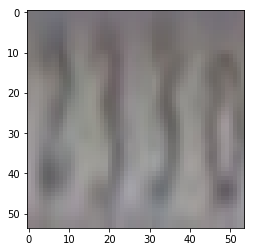

In [39]:
plt.figure()
plt.imshow(batch['image'][100])
print batch['label_list'][0][100]

In [ ]:
# Final evaluation of the model
predictions = conv_net.predict(test_data,batch_size=200, verbose=1)
combined_pred = np.array(predictions).argmax(axis=2).T
equiv = combined_pred==label_test
print 'digit acc' , float(np.sum(equiv))/10000
seq_acc = np.sum((equiv.sum(axis=1)==5))/2000.0
print 'sequence acc' , seq_acc

### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

## IOU
Adrian Rosebrock
http://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

Pixel coordinate refrences may be screwy if errors double check here!

In [ ]:
#Intersection over union
def iou(tt,lt,wt,ht,tg,lg,wg,hg):
    # determine the (x, y)-coordinates of the intersection rectangle
    li = max(lt, lg)
    bi = max(tt-ht, tg-hg)
    ri = min(lt+wt, lg+wg)
    ti = min(tt, tg)

    # compute the area of intersection rectangle
    interArea = (ri - li) * (ti - bi)

    # compute the area of both the prediction and ground-truth
    # rectangles
    train_area = wt*ht+1
    guess_area = wg*hg+1

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(train_area + guess_area - interArea)

    # return the intersection over union value
    return iou

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.